https://mscaudill.github.io/openseize/quickstart/

In [3]:
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from openseize import demos
from openseize import producer
from openseize.file_io import edf, annotations
from openseize.filtering import fir, iir
from openseize.spectra import estimators
from openseize.resampling import resampling


In [4]:


# Get access to the file's path locally, downloading if needed
# The eeg data will be used for both pipelines 1 and 2
eeg_path = demos.paths.locate('recording_001.edf')

# the annotations will be used in pipeline 2
annotes_path = demos.paths.locate('annotations_001.txt')


File saved to /home/julien/prog/apnea/venv/lib/python3.10/site-packages/openseize/demos/data/recording_001.edf
File saved to /home/julien/prog/apnea/venv/lib/python3.10/site-packages/openseize/demos/data/annotations_001.txt


In [5]:
# The reader is initialized with a path to the edf file
eeg_reader = edf.Reader(eeg_path)


In [6]:
# printing the reader shows the metadata 'Header' from the edf file
print(eeg_reader)

Reader Object
---Attributes & Properties---
{'path': PosixPath('/home/julien/prog/apnea/venv/lib/python3.10/site-packages/openseize/demos/data/recording_001.edf'),
 'mode': 'rb',
 'kwargs': {},
 'header': {'version': '0',
            'patient': 'PIN-42 M 11-MAR-1952 Animal',
            'recording': 'Startdate 15-AUG-2020 X X X',
            'start_date': '15.08.20',
            'start_time': '09.59.15',
            'header_bytes': 1536,
            'reserved_0': 'EDF+C',
            'num_records': 3775,
            'record_duration': 1.0,
            'num_signals': 5,
            'names': ['EEG EEG_1_SA-B', 'EEG EEG_2_SA-B', 'EEG EEG_3_SA-B',
                      'EEG EEG_4_SA-B', 'EDF Annotations'],
            'transducers': ['8401 HS:15279', '8401 HS:15279', '8401 HS:15279',
                            '8401 HS:15279', ''],
            'physical_dim': ['uV', 'uV', 'uV', 'uV', ''],
            'physical_min': [-8144.31, -8144.31, -8144.31, -8144.31, -1.0],
            'physical_max

In [7]:
# build a producer that will give us 100K samples at a time from all 4 channels
pro = producer(eeg_reader, chunksize=100e3, axis=-1)

In [8]:
# build a Finite Impulse Response filter to filter the 5 KHz data to 200 Hz.
# The gpass is the acceptable ripple in the pass band in dB and the gstop is
# the minimum attenuation in the  stop band. The transition band will 30 Hz wide
filt = fir.Kaiser(fpass=200, fstop=230, fs=5000, gpass=1, gstop=40)

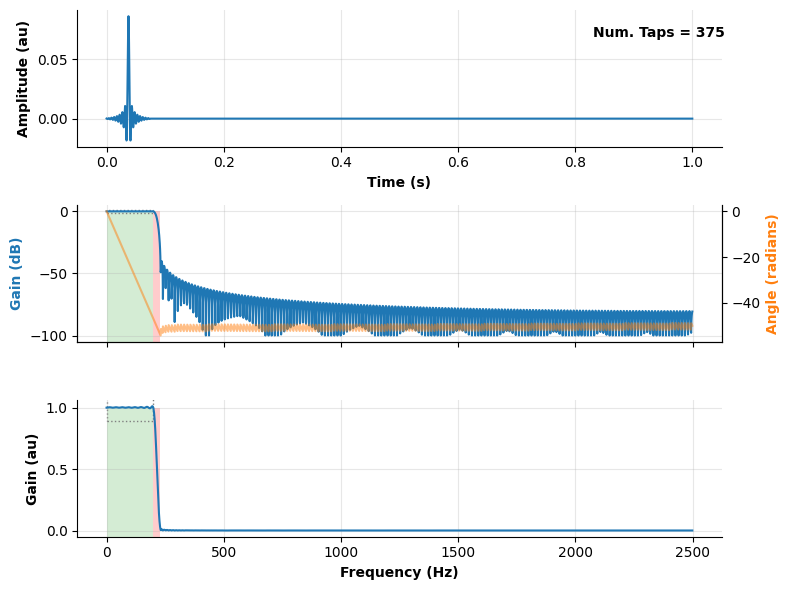

In [9]:
filt.plot()

In [10]:
# apply the filter to the producer using 100e3 elements from each channel
# this makes a new producer! The 'same' mode adjust for the filters delay.
filtpro = filt(pro, chunksize=100e3, axis=-1, mode='same')


In [12]:
# Openseize's PSD estimator returns the number of psd estimatives, the
# frequencies at which the PSD is estimated and an array 4 channels X 2500 Hz (i.e. the nyquist)
t0 = time.perf_counter()
cnt, freqs, results = estimators.psd(filtpro, fs=5000, axis=-1, resolution=0.5)
elapsed = time.perf_counter() - t0

msg = 'PSD computed on producer of shape ({}, {}) in {} secs'
print(msg.format(*filtpro.shape, elapsed))


PSD computed on producer of shape (4, 18875000) in 5.769950467999479 secs


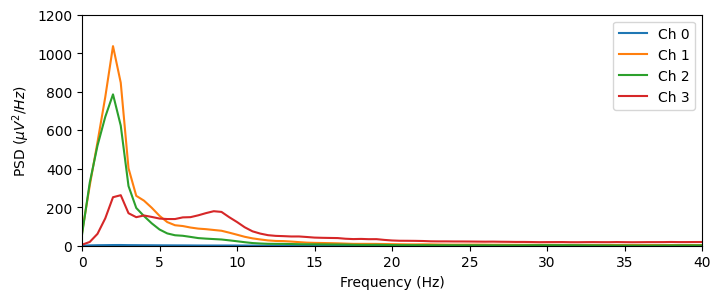

In [13]:
fig, ax = plt.subplots(figsize=(8,3))
for ch, arr in enumerate(results):

    ax.plot(freqs, arr, label='Ch {}'.format(ch))
    ax.legend()
    ax.set_xlim([0,40])
    ax.set_ylim(0, 1200)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(r'PSD ($\mu V^2 / Hz$)')

plt.show()



In [14]:
# Build the Pinnacle CSV reader and start reading from line 6
with annotations.Pinnacle(annotes_path, start=6) as reader:

    #call the readers read method to get all the annotations as a sequence of dataclasses
    annotes = reader.read()

# Filter the rest and exploring annotations and print them
rest_annotes = [ann for ann in annotes if ann.label=='rest']
explore_annotes = [ann for ann in annotes if ann.label=='exploring']

print(*rest_annotes, sep='\n')
print(*explore_annotes, sep='\n')

Annotation(label='rest', time=574.785, duration=5.0, channel='ALL')
Annotation(label='rest', time=1074.785, duration=5.0, channel='ALL')
Annotation(label='rest', time=2193.785, duration=5.0, channel='ALL')
Annotation(label='exploring', time=320.785, duration=5.0, channel='ALL')
Annotation(label='exploring', time=394.785, duration=5.0, channel='ALL')
Annotation(label='exploring', time=658.785, duration=5.0, channel='ALL')


In [15]:
# Build masks for the rest and exploring states
rest_mask = annotations.as_mask(rest_annotes, size=eeg_reader.shape[-1], fs=5000)
explore_mask = annotations.as_mask(explore_annotes, size=eeg_reader.shape[-1], fs=5000)

print('rest mask: ', rest_mask, rest_mask.shape)
print('explore mask: ', explore_mask, explore_mask.shape)

rest mask:  [False False False ... False False False] (18875000,)
explore mask:  [False False False ... False False False] (18875000,)


In [16]:


# set the chunksize to 10000 samples to load into memory at any one-time
rest_pro = producer(eeg_reader, chunksize=10000, axis=-1, mask=rest_mask)
explore_pro = producer(eeg_reader, chunksize=10000, axis=-1, mask=explore_mask)

# print the rest producer
print(rest_pro)


MaskedProducer Object
---Attributes & Properties---
{'data': ReaderProducer(data, chunksize, axis, **kwargs),
 'axis': -1,
 'kwargs': {},
 'mask': ArrayProducer(data, chunksize, axis, **kwargs),
 'chunksize': 10000,
 'shape': (4, 75000)}

Type help(MaskedProducer) for full documentation


In [17]:
rest_down_pro = resampling.downsample(rest_pro, M=25, fs=5000, chunksize=10000)
explore_down_pro = resampling.downsample(explore_pro, M=25, fs=5000, chunksize=10000)

print(rest_down_pro)

GenProducer Object
---Attributes & Properties---
{'data': functools.partial(<function polyphase_resample at 0x7efcb826b400>, MaskedProducer(pro, mask, chunksize, axis, **kwargs), 1, 25, 5000, <class 'openseize.filtering.fir.Kaiser'>, -1),
 'axis': -1,
 'kwargs': {},
 'chunksize': 10000,
 'shape': (4, 3000)}

Type help(GenProducer) for full documentation


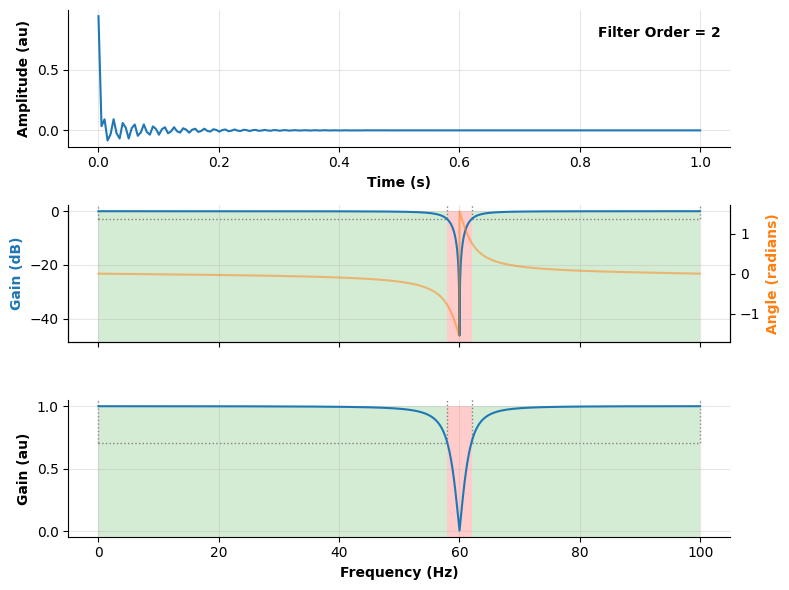

In [18]:
# build a notch filter that will stop 60 Hz with a width of 4 Hz on 200 Hz downsampled data
notch = iir.Notch(fstop=60, width=4, fs=200)
notch.plot()

In [19]:


# since the filter looks correct we can now apply it to the downsampling producer
# this gives us a new producer for each state
rpro = notch(rest_down_pro, chunksize=500, axis=-1)
epro = notch(explore_down_pro, chunksize=500, axis=-1)


In [20]:
# compute the PSD in each state -- this triggers all DSP operations to run iteratively
t0 = time.perf_counter()
rest_cnt, res_freqs, rest_results = estimators.psd(rpro, fs=200, axis=-1, resolution=0.5)
exp_cnt, exp_freqs, exp_results = estimators.psd(epro, fs=200, axis=-1, resolution=0.5)
print("rest and exploring PSDs computed in {} s".format(time.perf_counter() - t0))

rest and exploring PSDs computed in 7.811295396999412 s


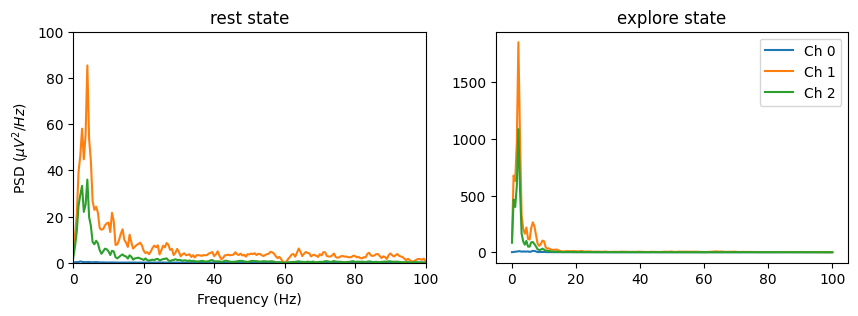

In [21]:
# plot the data of the EEG channels 0,1,2
fig, axarr = plt.subplots(1, 2, figsize=(10,3))
for ch, (rest, exp) in enumerate(zip(rest_results[:-1,:], exp_results[:-1,:])):

    axarr[0].plot(res_freqs, rest)
    axarr[1].plot(exp_freqs, exp, label='Ch {}'.format(ch))
    axarr[1].legend()
    axarr[0].set_xlim([0,100])
    axarr[0].set_ylim(0, 100)
    axarr[0].set_xlabel('Frequency (Hz)')
    axarr[0].set_ylabel(r'PSD ($\mu V^2 / Hz$)')
    axarr[0].set_title('rest state')
    axarr[1].set_title('explore state')

plt.show()

In [22]:
# show the file is still open by peeking at the secret file obj
print('Is the reader closed? {}'.format(eeg_reader._fobj.closed))

Is the reader closed? False


In [23]:
# to close the reader (and file object) just call the close method
eeg_reader.close()

In [24]:


# when we close the reader we set it to None, the reason for this
# is to support multiprocessing of producers which can not work
# with an open or closed file objects. Lets confirm the file
# object is closed by checking it is None

print(eeg_reader._fobj)


None
